# User Settings

In [ ]:
save_data = False
use_subset = True
subset_size = 1000

number_of_attacks = 1000
number_of_n_neighbors = 1

# Potentially known features by the attacker
aux_cat = ['gender', 'ethnicity', 'weekend_arrival', 'night_arrival']
aux_num = ['age']

# 1. Datengrundlage
## 1.1 Import

In [2]:
import pandas as pd
from pathlib import Path
from datetime import datetime

current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
data_path = Path("../../data/")

file_real = data_path / "20250301_data_20250421_133906_final_10_train.csv"
df_real = pd.read_csv(file_real, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_real = Path(file_real)
# print(df_real.head())

file_synth = data_path / "20250301_data_20250421_133906_final_synth_10_epochs.csv"
df_synth = pd.read_csv(file_synth, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_synth = Path(file_synth)
# print(df_synth.head())

file_holdout = data_path / "20250301_data_20250421_133906_final_10_holdout.csv"
df_holdout = pd.read_csv(file_holdout, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_holdout = Path(file_holdout)

In [3]:
numerical_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
categorical_cols = ['icu_admission_24h', 'gender', 'ethnicity', 'consciousness_level','news_score', 'night_arrival', 'weekend_arrival','chief_complaint', 'icd_block']

## 1.2 Subsets

In [ ]:
if use_subset:
    df_real     = df_real.sample(n=subset_size, random_state=42)
    df_synth    = df_synth.sample(n=subset_size, random_state=42)
    df_holdout  = df_holdout.sample(n=subset_size, random_state=42)

# 2. Funktion

In [ ]:
import numpy as np
import pandas as pd
from anonymeter.evaluators import LinkabilityEvaluator

evaluator_a1 = LinkabilityEvaluator(
    ori=df_real,
    syn=df_synth,
    aux_cols=(aux_cat, aux_num),
    n_attacks=number_of_attacks,    # optional: Anzahl Angriffe, Standard reicht oft
    n_neighbors=number_of_n_neighbors      # 1-Nearest Neighbor als Standard
)

evaluator_a2 = LinkabilityEvaluator(
    ori=df_holdout,
    syn=df_synth,
    aux_cols=(aux_cat, aux_num),
    n_attacks=number_of_attacks,
    n_neighbors=number_of_n_neighbors
)

evaluator_a3 = LinkabilityEvaluator(
    ori=df_real,
    syn=df_synth,
    control=df_holdout,
    aux_cols=(aux_cat, aux_num),
    n_attacks=number_of_attacks,    # optional: Anzahl Angriffe, Standard reicht oft
    n_neighbors=number_of_n_neighbors      # 1-Nearest Neighbor als Standard
)

print("Evaluating linkability...")
print("A1: Real vs. Synth")
evaluator_a1.evaluate(n_jobs=-1)  # parallele Ausführung
risk_a1, ci_a1 = evaluator_a1.risk(confidence_level=0.95)
# print(f"A1 Linkability Risk: {risk_a1:.4f}, 95% CI: {ci_a1}")

print("A2: Holdout vs. Synth")
evaluator_a2.evaluate(n_jobs=-1)
risk_a2, ci_a2 = evaluator_a2.risk(confidence_level=0.95)
# print(f"A2 Linkability Risk: {risk_a2:.4f}, 95% CI: {ci_a2}")

print("A3: Real vs. Synth with Holdout as Control")
evaluator_a3.evaluate(n_jobs=-1)
risk_a3, ci_a3 = evaluator_a3.risk(confidence_level=0.95)
# print(f"A3 Linkability Risk: {risk_a3:.4f}, 95% CI: {ci_a3}")




c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.004901898967320896, baseline = 0.005898072208835341. Analysis results cannot be trusted.
  self._sanity_check()
c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.
  self._sanity_check()


A1 Linkability Risk: 0.0049, 95% CI: (0.0010207838811386186, 0.008783014053503173)
A2 Linkability Risk: 0.0019, 95% CI: (0.0, 0.0038267584855551234)
A3 Linkability Risk: 0.0030, 95% CI: (0.0, 0.007327141416498274)


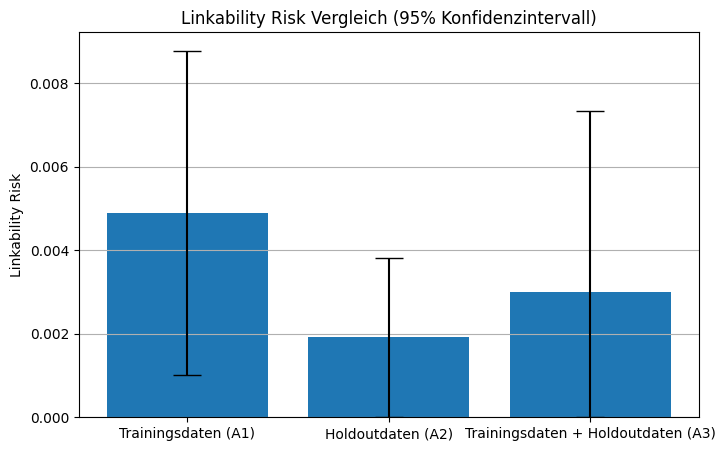

In [10]:
import matplotlib.pyplot as plt

risks = [risk_a1, risk_a2, risk_a3]
cis = [[risk_a1 - ci_a1[0], ci_a1[1] - risk_a1],
       [risk_a2 - ci_a2[0], ci_a2[1] - risk_a2],
       [risk_a3 - ci_a3[0], ci_a3[1] - risk_a3]]

labels = ['Trainingsdaten (A1)', 'Holdoutdaten (A2)', 'Trainingsdaten + Holdoutdaten (A3)']

plt.figure(figsize=(8, 5))
plt.bar(labels, risks, yerr=np.transpose(cis), capsize=10)
plt.ylabel('Linkability Risk')
# plt.ylim(0, 1)
plt.title('Linkability Risk Vergleich (95% Konfidenzintervall)')
plt.grid(axis='y')
plt.show()


# Iterieren über versch. Kombinationen

In [ ]:
from anonymeter.evaluators import LinkabilityEvaluator
import itertools
import pandas as pd

# Gegebene Attribute
aux_num = ['age']
aux_cat = ['gender', 'ethnicity', 'night_arrival', 'weekend_arrival', 'chief_complaint']

# Ergebnisse hier speichern
results = []

# Über alle möglichen Kombinationen der kategorialen Attribute (1 bis alle)
for r in range(1, len(aux_cat) + 1):
    for cat_subset in itertools.combinations(aux_cat, r):
        print(f"Evaluating with categorical attributes: {cat_subset} and numerical attributes: {aux_num}")
        print(f"Step {r} of {len(aux_cat)}")
        # Initialisierung des Evaluators
        evaluator = LinkabilityEvaluator(
            ori=df_real,            # oder df_holdout für andere Analyse
            syn=df_synth,
            control=df_holdout,
            aux_cols=(list(cat_subset), aux_num),
            n_attacks=number_of_attacks,
            n_neighbors=number_of_n_neighbors
        )
        
        # Berechnung
        evaluator.evaluate(n_jobs=-1)
        risk, ci = evaluator.risk(confidence_level=0.95)
        
        # Ergebnis speichern
        results.append({
            'categorical_attrs': ', '.join(cat_subset),
            'numerical_attrs': ', '.join(aux_num),
            'linkability_risk': risk,
            'ci_lower': ci[0],
            'ci_upper': ci[1]
        })

# Ergebnisse als DataFrame
linkability_df = pd.DataFrame(results)

# Ausgabe
# print(linkability_df)


c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.002909552484292007. Analysis results cannot be trusted.
  self._sanity_check()
c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.002909552484292007. Analysis results cannot be trusted.
  self._sanity_check()
c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0019133792427775617, baseline = 0.0019133792427775617. Analysis results cannot be trusted.
  self._sanity_check()
c:\Masterarbeit\venvs\anonymeter\lib\site-packages\anonymeter\stats\confidence.py:218: UserWarning: Attack is as good or worse as baseline

                                    categorical_attrs  ...  ci_upper
0                                              gender  ...  0.002711
1                                           ethnicity  ...  0.002711
2                                       night_arrival  ...  0.002711
3                                     weekend_arrival  ...  0.008167
4                                     chief_complaint  ...  0.005339
5                                   gender, ethnicity  ...  0.002711
6                               gender, night_arrival  ...  0.002711
7                             gender, weekend_arrival  ...  0.002711
8                             gender, chief_complaint  ...  0.006774
9                            ethnicity, night_arrival  ...  0.002711
10                         ethnicity, weekend_arrival  ...  0.008167
11                         ethnicity, chief_complaint  ...  0.002711
12                     night_arrival, weekend_arrival  ...  0.002711
13                     night_arriv

c:\Masterarbeit\venvs\anonymeter\lib\site-packages\upsetplot\data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
c:\Masterarbeit\venvs\anonymeter\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace

<Figure size 1200x600 with 0 Axes>

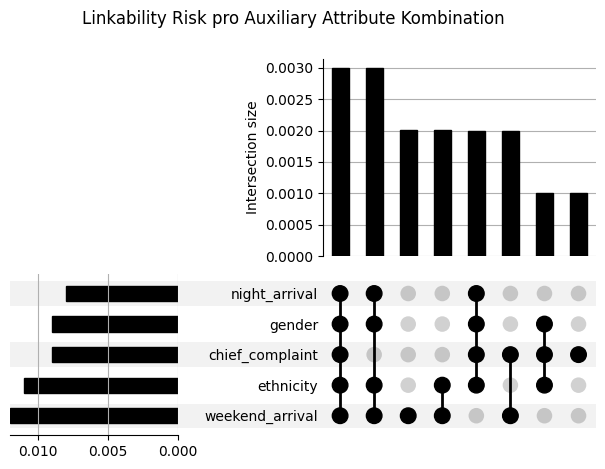

In [30]:
from upsetplot import from_memberships, UpSet
import matplotlib.pyplot as plt

# Vorbereitung der Membership-Liste
memberships = []
values = []

for _, row in plot_df.iterrows():
    # Split der kategorischen Attribute in Set
    attrs = [attr.strip() for attr in row['categorical_attrs'].split(',')]
    memberships.append(attrs)
    values.append(row['linkability_risk'])

# UpSet Data vorbereiten
upset_data = from_memberships(memberships, data=values)
n_categories = len(upset_data.index.names)

# UpSet-Plot
plt.figure(figsize=(12, 6))
upset = UpSet(
    upset_data, 
    show_counts=False, 
    show_percentages=False, 
    sort_by='input', 
    totals_plot_elements=n_categories,
    min_subset_size=0.0001)
upset.plot()
plt.suptitle('Linkability Risk pro Auxiliary Attribute Kombination')
plt.show()
